In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from publik import modifier
from publik import plot
from knunu_utils import * 

## Produce samples

In [2]:
sam_ana = analysis()
# sam_cvl = 6.0
# sam_csl = 2.0
# sam_ctl = 2.0
# sam_ana.parameters['sbnunu::Re{cVL}'].set(sam_cvl)
# sam_ana.parameters['sbnunu::Re{cSL}'].set(sam_csl)
# sam_ana.parameters['sbnunu::Re{cTL}'].set(sam_ctl)

In [3]:
p = sam_ana.parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=22.90)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})
pdf = eos.SignalPDF.make('B^-->K^-nunu::dGamma/dq2', p, k, o)

null_samples, pdf_values = pdf.sample_mcmc(50000, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

/home/l/Lorenz.Gaertner/publik-group/venv_publik_group/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Smear samples with Gaussian resolution function and apply efficiency


In [4]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

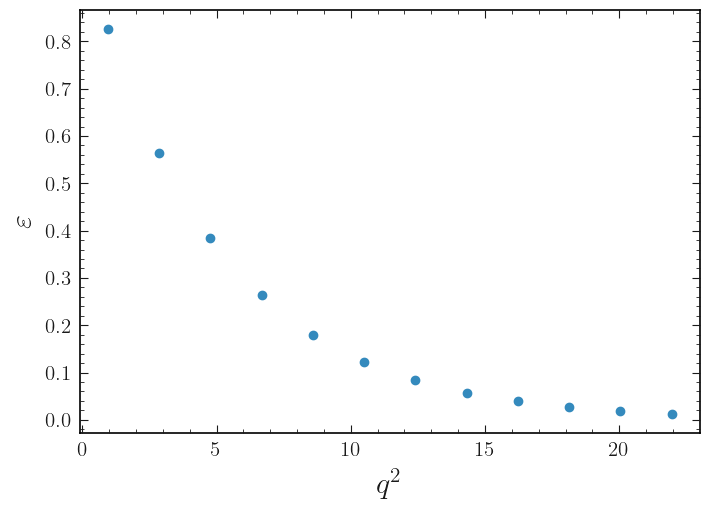

In [5]:
binning = np.linspace(0.0, 22.9, 13) 
bin_cents = (binning[:-1] + binning[1:])/2

plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

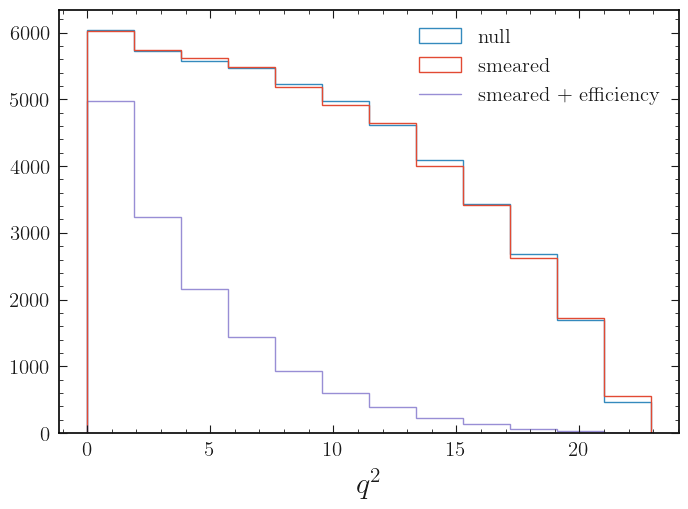

In [6]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

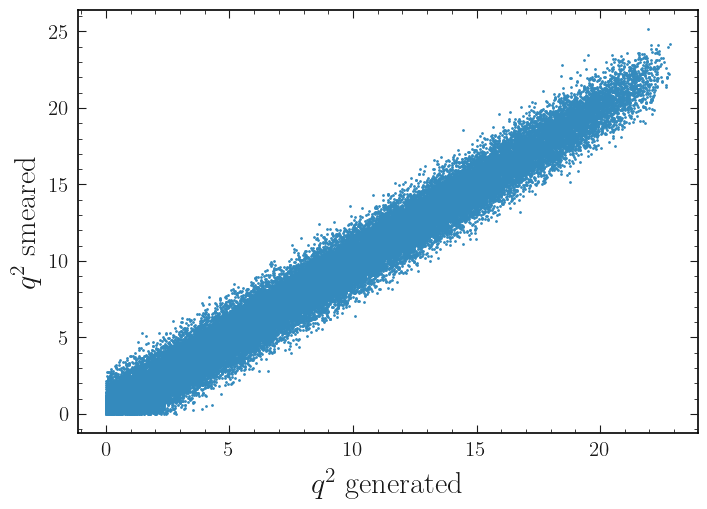

In [7]:
plt.scatter(null_samples, null_samples_smeared, s=1)
plt.xlabel(r'$q^2$ generated')
plt.ylabel(r'$q^2$ smeared')
plt.show()

## Define null and alternative predictions

In [8]:
ana = analysis()
cvl = ana.parameters['sbnunu::Re{cVL}'         ].evaluate()
csl = ana.parameters['sbnunu::Re{cSL}'         ].evaluate()
ctl = ana.parameters['sbnunu::Re{cTL}'         ].evaluate()
fp0 = ana.parameters['B->K::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->K::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->K::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->K::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->K::alpha^f0_2@BSZ2015'].evaluate()
fT0 = ana.parameters['B->K::alpha^fT_0@BSZ2015'].evaluate()
fT1 = ana.parameters['B->K::alpha^fT_1@BSZ2015'].evaluate()
fT2 = ana.parameters['B->K::alpha^fT_2@BSZ2015'].evaluate()

In [9]:
null = null_pred()
alt = alt_pred()

## Get covariance matrix of hadronic parameters

In [10]:
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

,0,1,2,3,4,5,6,7
0,0.000109,0.000696,0.000979,0.000775,0.001303,0.000088,0.000565,0.000760
1,0.000696,0.009307,0.021609,0.005688,0.010247,0.000392,0.006202,0.014710
2,0.000979,0.021609,0.067185,0.008526,0.017058,0.000097,0.011229,0.042544
3,0.000775,0.005688,0.008526,0.006233,0.011288,0.000612,0.004714,0.006588
4,0.001303,0.010247,0.017058,0.011288,0.022037,0.000978,0.008112,0.012782
5,0.000088,0.000392,0.000097,0.000612,0.000978,0.000473,0.003446,0.005830
6,0.000565,0.006202,0.011229,0.004714,0.008112,0.003446,0.031871,0.061918
7,0.000760,0.014710,0.042544,0.006588,0.012782,0.005830,0.061918,0.144128


## Set up mapping distribution

In [11]:
mapping_dist = np.histogram2d(null_samples.flatten(), null_samples_smeared.flatten(), bins=binning)[0].T
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [12]:
# TODO Why do I have to initialize csl and ctl to > 0. for the fit to work properly?
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.1,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.1,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FF'    :{'inits': (fp0, fp1, fp2, f01, f02, fT0, fT1, fT2), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, binning)
cmod.expanded_pyhf

{'custom': (publik.custom_modifier.add.<locals>._builder,
  publik.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

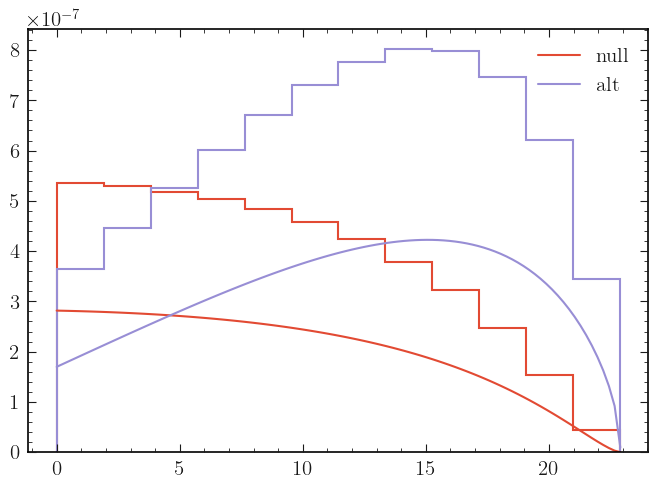

weights :  [0.68205075 0.84446179 1.01411677 1.19322938 1.38516801 1.59532707
 1.83293338 2.11522554 2.47869363 3.01679801 4.06251709 7.8291499 ]


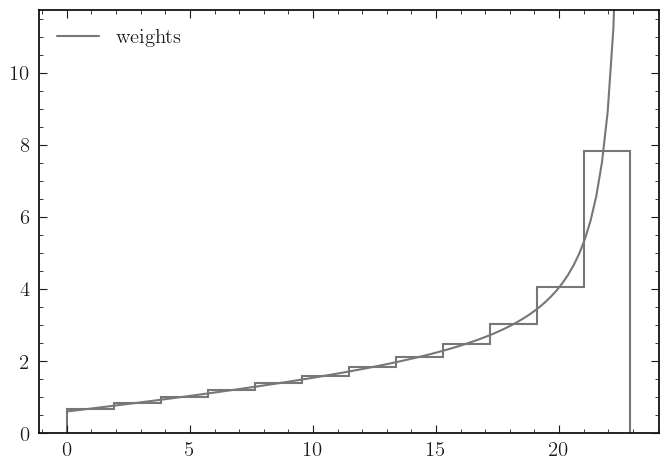

weights :  [0.68205075 0.84446179 1.01411677 1.19322938 1.38516801 1.59532707
 1.83293338 2.11522554 2.47869363 3.01679801 4.06251709 7.8291499 ]


In [13]:
cvl = 5.
csl = 3.
ctl = 2.

pars = (cvl, csl, ctl,fp0, fp1, fp2, f01, f02, fT0, fT1, fT2)
lims = [0.0, 22.9]
plot.dists(cmod, pars, lims)
plot.dists(cmod, pars, lims, plot_dists=False, plot_weights=True)

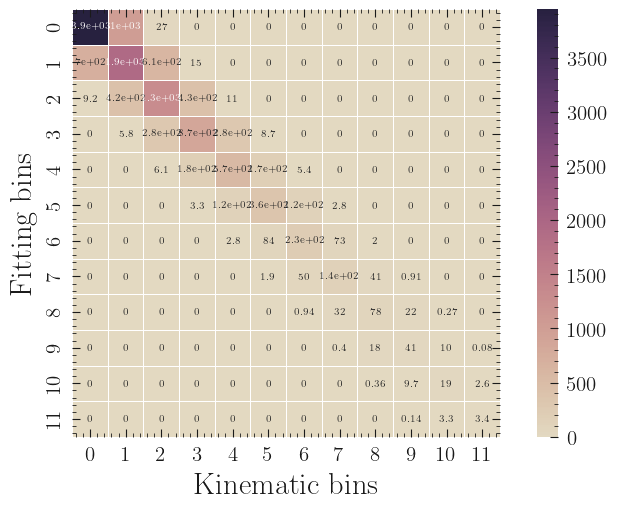

In [14]:
plot.map(cmod)

In [15]:
# Predicted yields for cvl = 5., csl = 3., ctl = 2.
alt_yields = [
       3559.11761564, 2708.10466905, 2179.68227147, 1739.30520023,
       1299.81298707,  971.6516827 ,  704.1145852 ,  491.4386929 ,
        328.84524717,  216.98647315,  118.396236  ,   42.8534169 
        ]

In [16]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields.tolist())
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [i for i in range(len(binning)-1)],
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
data = alt_yields + model.config.auxdata
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': [4980.757298418458,
      3234.0620700181285,
      2164.8323400131635,
      1440.642607455261,
      931.6795975805924,
      602.0074394725652,
      388.99795570876694,
      228.78869755844423,
      133.26659364327466,
      70.02874438533523,
      31.231153384210753,
      6.875731377529886],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': array([70.5744805 , 56.86881456, 46.52775881, 37.95579807, 30.52342703,
              24.5358399 , 19.7230311 , 15.12576271, 11.54411511,  8.36831789,
               5.588484  ,  2.62216158])},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}}]}]}]}

In [17]:
model.config.par_map

{'cvl': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x151404325970>},
 'csl': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x1514043259a0>},
 'ctl': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x1514043259d0>},
 'FF_decorrelated[0]': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x151404325a30>},
 'FF_decorrelated[1]': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x151404325a00>},
 'FF_decorrelated[2]': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x151404325a60>},
 'FF_decorrelated[3]': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x151404325a90>},
 'FF_decorrelated[4]': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at

Expected yields 
 array([3569.36530437, 2726.0003892 , 2201.08061281, 1723.9793104 ,
       1291.98677321,  964.20206239,  713.8815833 ,  484.30031348,
        330.68390495,  212.16681444,  126.04807089,   40.69244261])


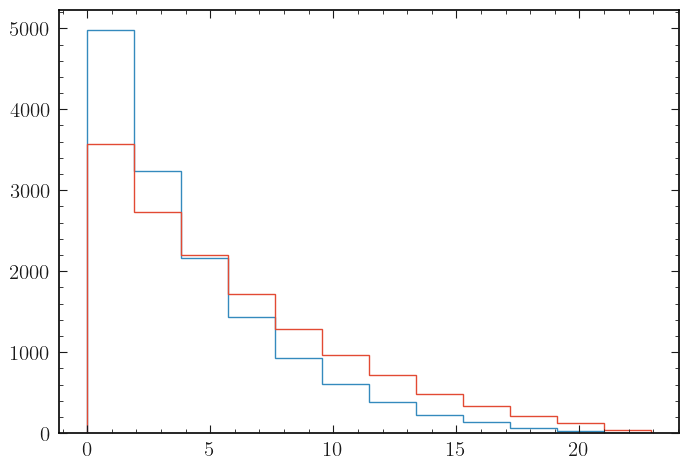

In [18]:
init = model.config.suggested_init()
init[0] = 5.
init[1] = 3.
init[2] = 2.
expected = model.expected_actualdata(init)

print('Expected yields \n', repr(expected))

plt.stairs(null_yields, binning)
plt.stairs(expected, binning)

## Perform the fit

In [19]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]


pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2, tolerance=1e-10))
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.256264


{'cvl': array([4.98130502, 0.18122712]),
 'csl': array([2.97523801, 0.44391733]),
 'ctl': array([2.03730848, 0.37532261]),
 'FF_decorrelated[0]': array([0.02727974, 0.98337796]),
 'FF_decorrelated[1]': array([-0.01377683,  0.99126608]),
 'FF_decorrelated[2]': array([-0.01737376,  0.98790857]),
 'FF_decorrelated[3]': array([0.00925043, 0.99197493]),
 'FF_decorrelated[4]': array([-0.00348637,  0.99316629]),
 'FF_decorrelated[5]': array([0.00225024, 0.99340946]),
 'FF_decorrelated[6]': array([-0.00245018,  0.99334596]),
 'FF_decorrelated[7]': array([-3.49244765e-04,  9.93358616e-01]),
 'mu': array([1., 0.]),
 'stat': [[1.0011258886813816, 0.013455496599700023],
  [0.9984879292783558, 0.014325852942523143],
  [0.9956236803362984, 0.016851789635615122],
  [1.0045830289709294, 0.020230913719816557],
  [1.002647958132514, 0.024134554412475306],
  [1.0034319336357274, 0.028503691567534628],
  [0.9895963926561708, 0.03373898766369465],
  [1.008521028090084, 0.04259058353620804],
  [0.9950753081

In [20]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 4.9813050154289575,
 'csl': 2.9752380130392995,
 'ctl': 2.0373084808285546,
 'FF[0]': 0.3378072344722878,
 'FF[1]': -0.8855682209495275,
 'FF[2]': -0.1115208827496255,
 'FF[3]': 0.3728587952632775,
 'FF[4]': 0.07642128071517833,
 'FF[5]': 0.3261249761425485,
 'FF[6]': -0.9686992022766229,
 'FF[7]': -0.28875719503547315,
 'mu': 1.0,
 'stat': [1.0011258886813816,
  0.9984879292783558,
  0.9956236803362984,
  1.0045830289709294,
  1.002647958132514,
  1.0034319336357274,
  0.9895963926561708,
  1.008521028090084,
  0.9950753081785798,
  1.017253680032714,
  0.9534383216194077,
  1.051247670980139]}

In [21]:
# TODO compute chi square between FF parameters

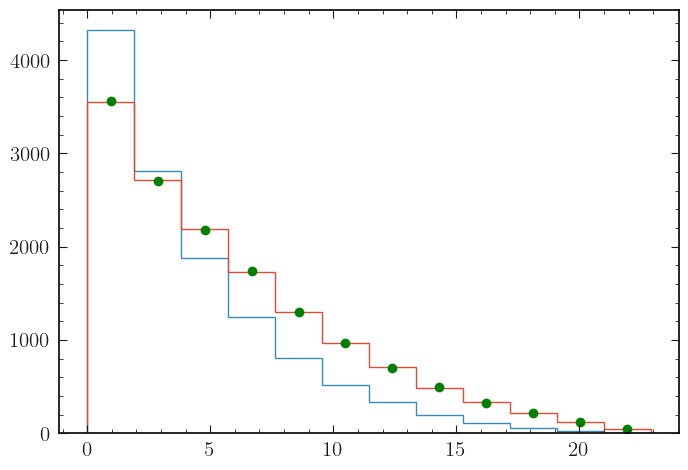

In [22]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')